In [1]:
import torch
from torch import nn
from torch.nn import functional
from torch.utils import data

import numpy as np
import matplotlib.pylab as plt

import argparse
import json
import networkx as nx
import random
import tqdm

In [2]:
# Graph dataset

class GraphsAlgebraicDataset(data.Dataset):
  """Dataset: graph laplacians and their algebraic connectivity."""

  def __init__(self, num_nodes, num_graphs):
    ds_adjs = []
    ds_algebs = []
    ds_num_nodes = []
    max_num_nodes = max(num_nodes)  # Used for padding.
    for i in range(num_graphs):
      #  Create equal number of graphs for number of nodes.
      idx = i % len(num_nodes)
      N = num_nodes[idx]
      g = self.random_graph(N, N)
      adj_ = np.asarray(nx.adjacency_matrix(g).todense()).astype(np.float32)
      adj_ = np.pad(adj_, ((0, max_num_nodes - N),)*2 , 'constant')
      ds_adjs.append(adj_)
      ds_algebs.append((nx.algebraic_connectivity(g)))
      ds_num_nodes.append(N)

    self.adjacencies = ds_adjs
    self.algebraics = ds_algebs
    self.num_nodes = ds_num_nodes

  def __len__(self):
    return len(self.adjacencies)

  def __getitem__(self, idx):
    adjacency = self.adjacencies[idx]
    algebraic = self.algebraics[idx]
    num_nodes = self.num_nodes[idx]
    sample = {'adjacency': adjacency, 'algebraic': algebraic, 'num_nodes': num_nodes}  
    return sample

  @staticmethod
  def random_graph(min_node, max_node):
    n_nodes = random.randint(min_node, max_node)
    gr = nx.generators.scale_free_graph(n_nodes)
    # This graph is directed, so we create an undirected version of it.
    # It also contains self-loops and duplicated edges.
    edges = set()
    for edge in gr.edges():
      if edge[0] == edge[1]:
        continue
      if (edge[1], edge[0]) in edges:
        continue
      edges.add(edge)
    graph = nx.Graph()
    graph.add_edges_from(edges)
    return graph
  

# Create dataset
batch_size = 10
num_graphs_train = 200
num_graphs_valid = 30
num_graphs_test = 30
num_nodes = [8, 9]  # range of number of nodes, N

train_set = GraphsAlgebraicDataset(num_nodes, num_graphs_train)
valid_set = GraphsAlgebraicDataset(num_nodes, num_graphs_valid)
test_set = GraphsAlgebraicDataset(num_nodes, num_graphs_test)

train_loader = data.DataLoader(train_set, batch_size=batch_size, shuffle=True)
valid_loader = data.DataLoader(valid_set, batch_size=batch_size)
test_loader = data.DataLoader(test_set, batch_size=batch_size)

for samples in train_loader:
  print("Adjacency dimensions:", samples['adjacency'].shape)
  print("Num nodes dimensions:", samples['num_nodes'].shape)
  print("Label dimensions:", samples['algebraic'].shape)
  break


Adjacency dimensions: torch.Size([10, 9, 9])
Num nodes dimensions: torch.Size([10])
Label dimensions: torch.Size([10])


In [3]:
# Model

# Simple linear layer
class MyModel(nn.Module):
  def __init__(self, F, Gs, K):
    """G: number of output features
       K: number of hops 
       L: number of layers """
    super(MyModel, self).__init__()   
    
    self.Gs = Gs
    self.K = K
    L = len(Gs)  # Each layer has its own number of output features.
    self.L = L

    # List of linear models
    self.linears = []  # Array of A_k matrices for each hop
    for l in range(L):
      layer_linears = []
      l_in = F if l==0 else Gs[l-1]
      l_out = Gs[l]
      for k in range(K):
        layer_linears.append((nn.Linear(l_in, l_out, bias=False))) # A_k in paper
      self.linears.append(layer_linears)

    # Input size is output of last layer's Linear 
    self.linear_final = nn.Linear(Gs[-1], 1)
    self.activation = nn.ReLU()


  def forward(self, x, s):
    """x: observation, dim = B x N x F
       s: adjacency matrix, dim = B x N x N
       output, dim = B x N x G """
    batch_size = x.shape[0]
    N = x.shape[1]

    #  Iterate over layers and comm hops
    for l in range(self.L):
      sxa = torch.zeros(batch_size, N, self.Gs[l])
      # S^0 does not communicate, multiply by identity
      sk = torch.eye(N).expand_as(s)
      for k in range(self.K):
        sx = torch.matmul(sk, x)
        sxa_ = self.linears[l][k](sx)  # S^k X A_k, where linear layer learns A_k
        sxa += sxa_  # Aggregate
        # Take the k-th power of s
        sk = torch.matmul(s, sk)
      x = self.activation(sxa)

    out = self.linear_final(x)  # input: N x G, output: N x 1
    return out




In [4]:
# Configuration

num_in_features = 4  # F
num_out_features = [3, 3]  # G
num_layers = len(num_out_features)  # L
num_hops = 3  # K; K=1: 0 hops, K=2: 1 hop, etc.

# Test the model with 1 batch
test_model = MyModel(num_in_features, num_out_features, num_hops)

for samples in train_loader:
  print("Data shape", samples['adjacency'].shape)
  num_nodes = samples['adjacency'].shape[1]
  x = torch.ones(batch_size, num_nodes, num_in_features)  # dim = B x N x F
  out = test_model(x, samples['adjacency'])
  labels = samples['algebraic'].reshape([batch_size, 1, 1]).expand(-1, num_nodes, -1)

  print("Out shape:", out.shape)
  print("Label shape: ", labels.shape)
  break

Data shape torch.Size([10, 9, 9])
Out shape: torch.Size([10, 9, 1])
Label shape:  torch.Size([10, 9, 1])


In [5]:
def padded_mse_loss(outputs, target, num_nodes):
  mse = padded_operation(outputs, target, num_nodes, lambda a, b: (a-b)**2)
  return torch.mean(mse)

def padded_errors(outputs, target, num_nodes):
  return padded_operation(outputs, target, num_nodes, lambda a, b: (a-b))

def padded_operation(outputs, target, num_nodes, criterion_fn):
  batch_size = outputs.shape[0]
  max_num_nodes = outputs.shape[1]

  labels = target.reshape([batch_size, 1, 1]).expand(-1, max_num_nodes, -1)
  error = criterion_fn(outputs, labels) 

  # Compute indeces that belong to non-padded error values
  idx = torch.arange(max_num_nodes).reshape([1, max_num_nodes, 1]).expand(batch_size, -1, -1)
  num_nodes_reshaped = torch.reshape(num_nodes, [batch_size, 1, 1]).expand(-1, max_num_nodes, -1)
  idx = (idx < num_nodes_reshaped).float()

  #  Consider only non-padded error values for mse.
  errors = torch.sum(error * idx, [1, 2]) / num_nodes
  return errors

print(padded_mse_loss(out, samples['algebraic'], samples['num_nodes']).shape)
print(padded_errors(out, samples['algebraic'], samples['num_nodes']).shape)

torch.Size([])
torch.Size([10])


Epoch: 0 | Loss (train): 0.9449 | Loss (valid): 0.9794
Epoch: 10 | Loss (train): 0.1255 | Loss (valid): 0.1510
Epoch: 20 | Loss (train): 0.0972 | Loss (valid): 0.1140
Epoch: 30 | Loss (train): 0.0732 | Loss (valid): 0.0826
Epoch: 40 | Loss (train): 0.0558 | Loss (valid): 0.0606
Epoch: 50 | Loss (train): 0.0444 | Loss (valid): 0.0464
Epoch: 60 | Loss (train): 0.0377 | Loss (valid): 0.0384
Epoch: 70 | Loss (train): 0.0342 | Loss (valid): 0.0345
Epoch: 80 | Loss (train): 0.0326 | Loss (valid): 0.0332
Epoch: 90 | Loss (train): 0.0317 | Loss (valid): 0.0324
Epoch: 100 | Loss (train): 0.0316 | Loss (valid): 0.0323
Epoch: 110 | Loss (train): 0.0316 | Loss (valid): 0.0323
Epoch: 120 | Loss (train): 0.0316 | Loss (valid): 0.0323
Epoch: 130 | Loss (train): 0.0316 | Loss (valid): 0.0323
Epoch: 140 | Loss (train): 0.0316 | Loss (valid): 0.0323
Epoch: 150 | Loss (train): 0.0316 | Loss (valid): 0.0323
Epoch: 160 | Loss (train): 0.0316 | Loss (valid): 0.0323
Epoch: 170 | Loss (train): 0.0316 | Loss (

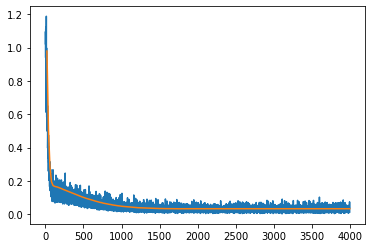

In [6]:
# Training

# CUDA for PyTorch
device = torch.device("cuda:0" if torch.cuda.is_available() else "cpu")

model = MyModel(num_in_features, num_out_features, num_hops)
# Initial message sent across nodes
# x_input = torch.ones(batch_size, num_nodes, num_in_features)  # dim = B x N x F

model = model.to(device)

max_epochs = 200
learning_rate = 0.001
optimizer = torch.optim.Adam(model.parameters(), lr=learning_rate)
lr_lambda = lambda epoch: 0.95 ** epoch
# scheduler = torch.optim.lr_scheduler.LambdaLR(optimizer, lr_lambda=lr_lambda)
scheduler = torch.optim.lr_scheduler.ReduceLROnPlateau(optimizer, 'min', patience=2, factor=0.1)

# Loop over epochs
train_errors = []
valid_errors = []
valid_errors_steps = []
step_counter = 0
for epoch in range(max_epochs):
  train_running_loss = 0.0

  model.train()
  # Training
  for i, samples in enumerate(train_loader):
    # Transfer to GPU
    adjacencies = samples['adjacency'].to(device)
    # Forwards pass
    batch_size = adjacencies.shape[0]
    max_num_nodes = adjacencies.shape[1]
    x_input = torch.ones(batch_size, max_num_nodes, num_in_features)
    outputs = model(x_input, adjacencies)
    # Labels
    labels = samples['algebraic'].to(device)
    # Number of nodes.
    num_nodes = samples['num_nodes'].to(device)

    # Compute loss
    loss = padded_mse_loss(outputs, labels, num_nodes)
    
    # Zero gradients, compute backwards pass, update weights
    optimizer.zero_grad()
    loss.backward()
    # Update model parameters
    optimizer.step()
    step_counter += 1

    train_running_loss += loss.detach().item()
    train_errors.append(loss.detach().item())
  train_running_loss /= i

  # validation error
  model.eval()
  valid_running_loss = 0.0
  for i, samples in enumerate(valid_loader):
    adjacencies = samples['adjacency'].to(device)
    labels = samples['algebraic'].to(device)
    num_nodes = samples['num_nodes'].to(device)
    # Forwards pass
    batch_size = adjacencies.shape[0]
    max_num_nodes = adjacencies.shape[1]
    x_input = torch.ones(batch_size, max_num_nodes, num_in_features)
    outputs = model(x_input, adjacencies) 
    loss = padded_mse_loss(outputs, labels, num_nodes)
    valid_running_loss += loss.detach().item()
  valid_running_loss /= i
  valid_errors.append(valid_running_loss)
  valid_errors_steps.append(step_counter)

  # print training loss
  if epoch % 10 == 0:
    print('Epoch: %d | Loss (train): %.4f | Loss (valid): %.4f' %(epoch, train_running_loss, valid_running_loss)) 

  scheduler.step(valid_running_loss)

plt.plot(train_errors)
plt.plot(valid_errors_steps, valid_errors)


30
0.11962457070981505


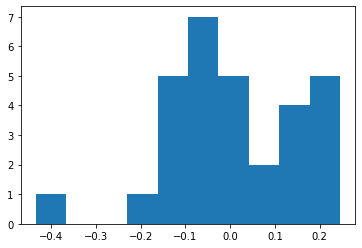

In [7]:
# Test results

errors = []
model.eval()
for samples in test_loader:
  adjacencies = samples['adjacency'].to(device)
  labels = samples['algebraic'].to(device)
  num_nodes = samples['num_nodes'].to(device)   
  # Forwards pass
  outputs = model(x_input, adjacencies)
  # Compute error
  err = padded_errors(outputs, labels, num_nodes)
  errors.extend(err.detach())
 
    
print(len(errors))
plt.hist(errors, bins=10);

print(np.mean(np.abs(errors)))

tensor([[0.5763],
        [0.6054],
        [0.6252],
        [0.5694],
        [0.5384],
        [0.5371],
        [0.5371],
        [0.5372],
        [0.6306]])


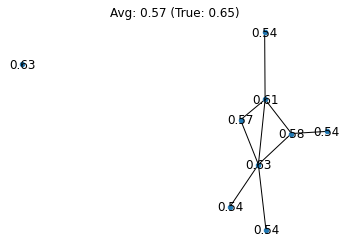

In [8]:
# Visualize an example estimates


idx = 0  # Sample index

out = outputs[idx,:,:].detach()
print(out)
out_avg = np.average(out.numpy())

#  Create graph and node-level estimates
gr = nx.from_numpy_matrix(adjacencies[idx].numpy())
ax = plt.subplot(1,1,1)
prediction_per_node = dict((k, '%.2f' % v) for k, v in enumerate(out.numpy()))
#print("True value: ", labels[idx, 0].numpy())

nx.draw(gr, ax=ax, node_size=20, with_labels=True, labels=prediction_per_node)
plt.title('Avg: %.2f (True: %.2f)' % (out_avg, labels[idx].numpy()));

